# IA Paper 1 - Mechanics - Examples paper 1

## Question 1 - Programming Extension

There is no general analytical solution describing the movement of three or more bodies interacting with each other through between them, e.g. gravity. Under certain circumstances, such as our solar system, the resulting
trajectories are periodic. In others the trajectories become chaotic. The three body problem can be solved using numerical methods which provide approximate solutions.

Write a basic script to simulate the movement of the earth and the moon around the sun, using both Euler and Verlet integration algorithm. 

### Solution

#### Forward Euler method

A basic approach is to use the *forward Euler method*. If $\boldsymbol{r}(t)$, $\boldsymbol{v}(t)$ and $\boldsymbol{a}(t)$ are the position, velocity and acceleration of a body at time $t$ then the position and velocity at time $t + \Delta t$ can be approximated by:

\begin{align}
\boldsymbol{r}(t + \Delta t) 
  &= \boldsymbol{r}(t) + \boldsymbol{v}(t)\Delta t + \dfrac{1}{2}\boldsymbol{a}(t)\Delta t^2, 
\\ 
\boldsymbol{v}(t + \Delta t) &= \boldsymbol{v}(t) + \boldsymbol{a}(t)\Delta t.
\end{align}

The acceleration of body $i$, $\boldsymbol{a}_{i}$, can be calculated from the forces acting on the body divided 
by its mass, e.g.

$$
\boldsymbol{a}_{i} = \dfrac{1}{m_i}\sum_{j, j \neq i} \boldsymbol{F}_{ij},
$$

where $\boldsymbol{F}_{ij}$ is the net force acting on mass $i$ by mass $j$, in this case the net gravitational force acting on the planet. *You will need to find actual values of the masses of the Earth, the moon and the sun from the literature, along with their relative distances and speed.* 


#### Verlet method

A more accurate method to calculate the positions of a body moving under the influence of a force is the *Verlet algorithm*. It approximates the velocity at $t + \Delta t$ as:

$$
\boldsymbol{v}(t + \Delta t) = \boldsymbol{v}(t) 
+ \dfrac{1}{2} \left( \boldsymbol{a}(t) + \boldsymbol{a}(t + \Delta t) \right) \Delta t,
$$

where $\boldsymbol{a}(t + \Delta t)$ is calcualted from the forces acting on the body at position $\boldsymbol{r}(t + \Delta t)$. The position $\boldsymbol{r}(t + \Delta t)$ is calculated in the same way as in the Euler method.

Let's begin with importing the necessary modules, `numpy` and `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

%matplotlib inline

We will be calculating the gravitational force multiple times, so it is convenient to implement a a function `gravitation`. The function calculate the gravitational force vector between two input masses `m1` and `m2` separated by distance vector `r`. The vector equation, to account for the direction of the gravitational force, can be written as:

\begin{align}
    \boldsymbol{F}_{ij} &= - \dfrac{G m_1 m_2}{d^2} \boldsymbol{\hat{r}}_{ij} 
\end{align}

where $d = |\boldsymbol{r}_{ij}|^2$ and $\boldsymbol{\hat{r}}_{ij}$ is the unit vector in the direction from mass $i$ to mass $j$.

Since we only have three planets here, each planet will have the gravitational force from the other two planets acting on it. Hence, we can introduce our following function to calculate the *net* gravitational force on a planet. It is worth noted here that the sign of `r1` and `r2` can be changed to determine the *direction* of the force, which is important for our numerical integration later on. 

In [2]:
def net_gravitation(M, m1, r1, m2, r2, G):
    # Returns the net gravitational force vector acting on
    # M by mass m1 at distance r1 and mass m2 by distance r2
    # mass m1 and m2 separated by a distance vector r
    
    # Force acting by m1
    d1 = np.linalg.norm(r1)
    f1 = (G*M*m1/(d1**2))*r1/d1
    
    # Force acting by m2
    d2 = np.linalg.norm(r2)
    f2 = (G*M*m2/(d2**2))*r2/d2
    
    return f1 + f2

We then initialise the time step $\Delta t$ for our simulation. We want to obtain one full revolution of the earth around the sun - over a simulation period of 365 days. Students are encouraged to alter the simulation period and the time step to examine the differences between the Euler and Verlet algorithm. 

In [3]:
# Simulation time in days
# TO BE CHANGED BY STUDENTS
t_0 = 0          # Start time
t_e = 365      # End time
dd = 3          # Number of time steps per day
num_step = (t_e - t_0)*dd  # Total number of time steps
t = np.linspace(t_0, t_e, num_step+1)
Dt = np.diff(t)*24*3600  # Time step in s

Now we initialise the parameters - including the masses, relative distances and relative speeds for the Earth, moon and the sun. 

In [4]:
# Body masses in kg
m_s = 1.988e30   # Sun
m_e = 5.972e24   # Earth
m_m = 7.346e22   # Moon

# Distances in m
d_se = 149.598e9   # Sun - Earth
d_em = 384.400e6   # Earth - Moon

# Relative speed in m s^-1
s_e = 107208e3/3600  # Earth relative to Sun
s_m = 3670e3/3600   # Moon relative to Earth

# Gravitational constant in m^3 kg^-1 s^-2
G = 6.6738e-11

The simulation requires initial conditions - positions and velocities - to run, where students can set up for varied scenarios. The positions of the earth and moon will be stored in $n \times 2$ column vectors for subsequent plotting, while only the current velocities are kept. *For extra, edit the codes to collect the velocities of the Earth and the moon as well.*

In [5]:
def simulation_init(n):
    # Initial conditions
    # Initialise positions [x, y] in m
    r_e = np.zeros([n + 1, 2])   # Earth position
    r_m = np.zeros([n + 1, 2])   # Moon position

    # Starting positions relative to Sun
    # Here: Sun, Earth and Moon in one line
    # FOR STUDENTS: Try out different starting positions
    r_e[0, :] = d_se*np.array([1.0, 0.0])           # Earth
    r_m[0, :] = (d_se + d_em)*np.array([1.0, 0.0])  # Moon

    # Starting velocity relative to Sun
    # Here: If Sun, Earth, Moon starts along x-axis then
    # their initial velocities are along y axis
    v_e = s_e*np.array([0.0, 1.0])          # Earth
    v_m = (s_e + s_m)*np.array([0.0, 1.0])  # Moon

    return r_e, r_m, v_e, v_m

Having defined all the parameters and the initial conditions, we are now ready to run the numerical algorithm. The following codes include the simulation for both Verlet and Euler algorithm. Students are advised to take extra care when considering the direction of the graviational forces on a body mass. Appropriate comments are provided to assist understanding.

In [6]:
def simulation(method, n):
    r_e, r_m, v_e, v_m = simulation_init(n)

    # Run simulation
    for i in range(num_step-1):
        r_se = r_e[i, :]   # Sun -> Earth
        r_sm = r_m[i, :]   # Sun -> Moon
        r_em = r_sm - r_se  # Earth -> Moon

        # Forces acting on Earth
        f_e = net_gravitation(m_e, m_s, -r_se, m_m, r_em, G)

        # Force acting on Moon
        f_m = net_gravitation(m_m, m_s, -r_sm, m_e, -r_em, G)

        # Acceleration
        a_e = f_e/m_e    # of Earth
        a_m = f_m/m_m    # of Moon

        # Update positions from velocity and acceleration
        r_e[i+1, :] = r_e[i, :] + v_e*Dt[i] + 0.5*a_e*(Dt[i]**2)
        r_m[i+1, :] = r_m[i, :] + v_m*Dt[i] + 0.5*a_m*(Dt[i]**2)

        # Numerical integration
        if method == 'Verlet':
            # Acceleration at position r[t+dt] for Earth
            r_se = r_e[i+1, :]
            a_e2 = net_gravitation(m_e, m_s, -r_se, m_m, -r_em, G)/m_e
    
            # Velocity at position r[t+dt] for Earth
            v_e = v_e + 0.5*(a_e+a_e2)*Dt[i]

            # Acceleration at position r[t+dt] for Moon
            r_sm = r_m[i+1, :]
            r_em = r_sm - r_se
            a_m2 = net_gravitation(m_m, m_e, -r_em, m_s, -r_sm, G)/m_m

            # Velocity at position r[t+dt] for moon
            v_m = v_m + 0.5*(a_m + a_m2)*Dt[i]

        elif method == 'Euler':
            v_e = v_e + a_e*Dt[i]
            v_m = v_m + a_m*Dt[i]

    # Return the results of the simulation
    return r_e, r_m, v_e, v_m

Let's compare the results obtained from two different algorithms. We plot the trajectory of the Earth - in blue - and the moon - in red - around the sun - in yellow. 

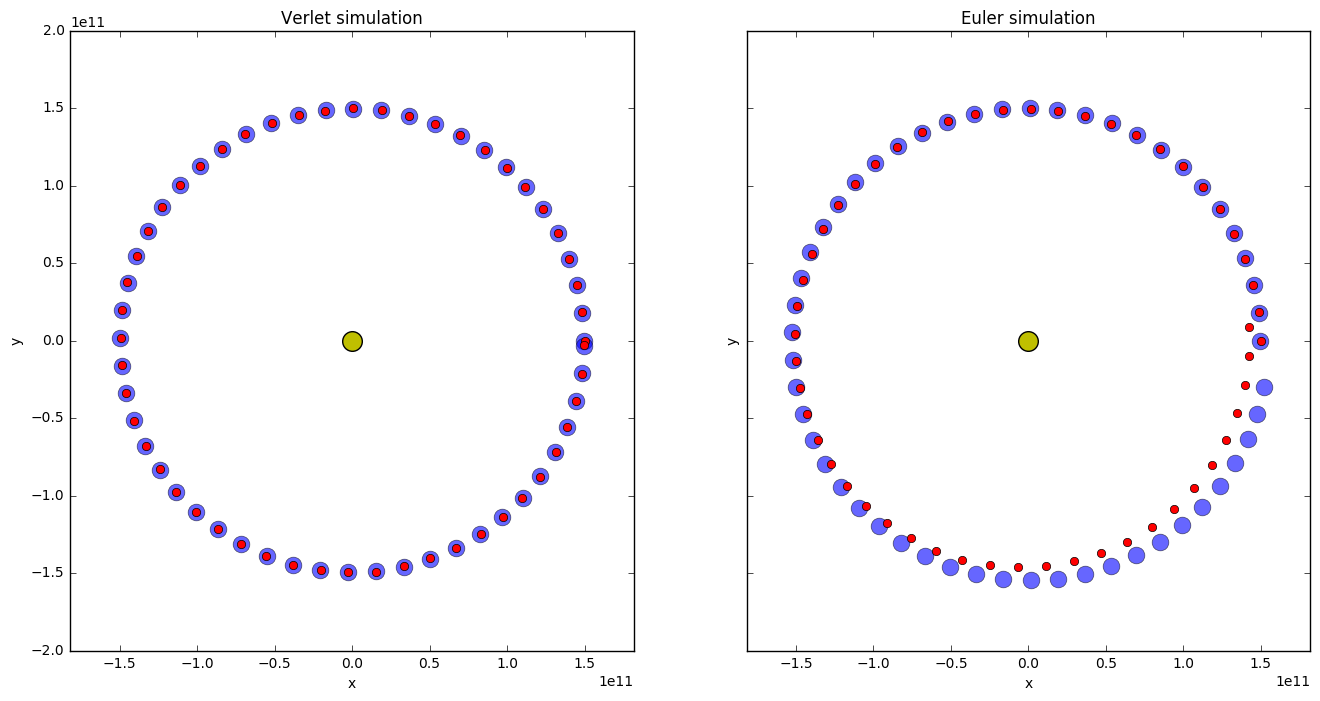

In [7]:
# Plot the result simulation

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))

# Get the Verlet simulation result
r_e, r_m, v_e, v_m = simulation('Verlet', num_step)

# Pick out some data points
p = np.arange(0, num_step, dd*7)
ax1.scatter([0], [0], s=200, c='y')
ax1.plot(r_e[p, 0], r_e[p, 1], 'bo', alpha=0.6, markersize=12)
ax1.plot(r_m[p, 0], r_m[p, 1], 'ro')
ax1.set_title('Verlet simulation')
ax1.axis('equal')
ax1.axis([-2e11, 2e11, -2e11, 2e11])
ax1.set_xlabel('x')
ax1.set_ylabel('y');

# Get the Euler simulation result
r_e, r_m, v_e, v_m = simulation('Euler', num_step)

# Pick out some data points
ax2.scatter([0], [0], s=200, c='y')
ax2.plot(r_e[p, 0], r_e[p, 1], 'bo', alpha=0.6, markersize=12)
ax2.plot(r_m[p, 0], r_m[p, 1], 'ro')
ax2.set_title('Euler simulation')
ax2.axis('equal')
ax2.axis([-2e11, 2e11, -2e11, 2e11])
ax2.set_xlabel('x')
ax2.set_ylabel('y');

We can even do a side-by-side comparison at each iteration using the following widget. Full understanding of the code is not required, though curious students are encouraged to investigate. 

In [8]:
# Let's try an interactive notebook
from ipywidgets import *

current_method = 'Euler'

def plot_sun_earth_moon(method, i):
    # Declare the global variables so we can avoid re-running 
    # the simulation everytime
    global current_method
    global r_e, r_m, v_e, v_m

    # Get the simulation result
    if current_method is not method:
        r_e, r_m, v_e, v_m = simulation(method, num_step)
        current_method = method

    # Pick out some data points
    plt.figure(figsize=(8, 8))
    plt.scatter([0], [0], s=200, c='y')
    plt.plot(r_e[i, 0], r_e[i, 1], 'bo', alpha=0.6, markersize=12)
    plt.plot(r_m[i, 0], r_m[i, 1], 'ro')
    plt.axis('equal')
    plt.axis([-2e11, 2e11, -2e11, 2e11])
    plt.xlabel('x')
    plt.ylabel('x')

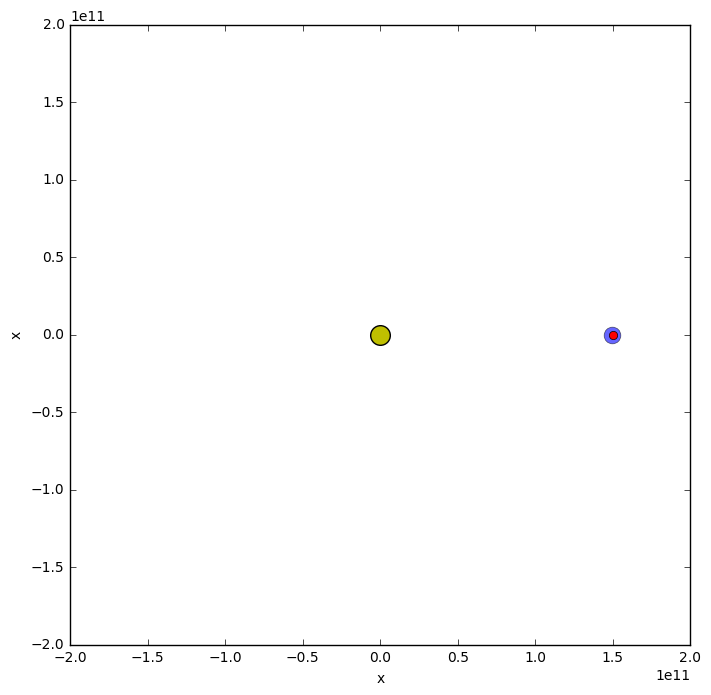

In [9]:
interact(plot_sun_earth_moon, method=('Euler', 'Verlet'),
         i=IntSlider(min=0, max=1000, step=10, value=0, description='Iter'));

## Question 5

A particle $P$ moves along a curve whose parametric equations using cartesian coordinates are

\begin{align}
r_x &= \exp \left( -\dfrac{t}{T_1} \right) 
\\
r_y &= 2 \cos \left(\dfrac{t}{T_2}\right)
\end{align}

where the distances $x$ and $y$ are in metres, $t$ is the time in seconds and the time constants $T_1 = 1$ s and $T_2 = 1/3$ s. 

Plot the trajectory of the particle in the $xy$-plane over the time interval $t = 0$ to $t = 2\pi$ s. On the graph, identify the particle’s locations at $t = 0$, $\pi/2$ and $2\pi$? Experiment with the number of points in the `np.linspace` command to make the trajectory look more accurate and smoother. Calculate the velocity and acceleration in the $x$ and $y$ directions and plot them on separate graphs for each direction. Verify that the numerical answers agrees with your analytical solutions, paying attention at the locations of the extrema and zero crossings.

** HINT ** 
You can use `np.linspace(start, end, number of elements)` to generate an 'array' of equally 
spaces points on the interval `[start, end)`, e.g. `np.linspace(0, 2*np.pi, 20)` to create 20 times . The x-coordinate can then be defined using `r_x=np.exp(-t)`. Define the y-coordinate in a similar way and plot the trajectory using the plot command.

### Solution

In [10]:
# Special command for plotting in jupyter notebooks
%matplotlib inline

First import the required modules - `numpy` and `matplotlib`. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Change matplotlib fontsize and line width
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'lines.linewidth': 2.0})

Initially, it is good to have a look at our reference solution. Based on the given formula for the trajectory of the partical, we can work out the formula for its velocity as:

\begin{align}
v_x &= -\dfrac{1}{T_1}\exp \left( -\dfrac{t}{T_1} \right) 
\\
v_y &= -\dfrac{2}{T_2} \sin \left(\dfrac{t}{T_2}\right)
\end{align}

and acceleration as:

\begin{align}
a_x &= \dfrac{1}{T^2_1} \exp \left( -\dfrac{t}{T_1} \right) 
\\
a_y &= -\dfrac{2}{T^2_2} \cos\left(\dfrac{t}{T_2}\right)
\end{align}

We declare our constants as followed.

In [12]:
# Declare the time constants
T1 = 1.0
T2 = 1.0/3.0

Then initialise the array to store our reference results. Here, our positions, velocities and accelerations of the particles in time are stored as 2D array of vectors - the first column corresponds to the $x$ component, and the second the $y$ component. 

In [13]:
# Initialise array for position, velocity and acceleration
num_points = 500
r_ref = np.zeros((num_points, 2))
v_ref = np.zeros((num_points, 2))
a_ref = np.zeros((num_points, 2))

# Generate the reference time vector
t_ref = np.linspace(0, 2*np.pi, num_points)

The results can be calculated using the formula provided above.

In [14]:
# Calculate the x and y coordinates of the particle
r_ref[:, 0] = np.exp(-t_ref/T1)
r_ref[:, 1] = 2.0*np.cos(t_ref/T2)

# Exact solution for velocity
v_ref[:, 0] = -(1.0/T1)*np.exp(-t_ref/T1)
v_ref[:, 1] = -(2.0/T2)*np.sin(t_ref/T2)

# Exact solution for acceleration
a_ref[:, 0] = (1.0/(T1**2))*np.exp(-t_ref/T1)
a_ref[:, 1] = -(2.0/(T2**2))*np.cos(t_ref/T2)

We can now plot the postion, velocity and acceleration fields.

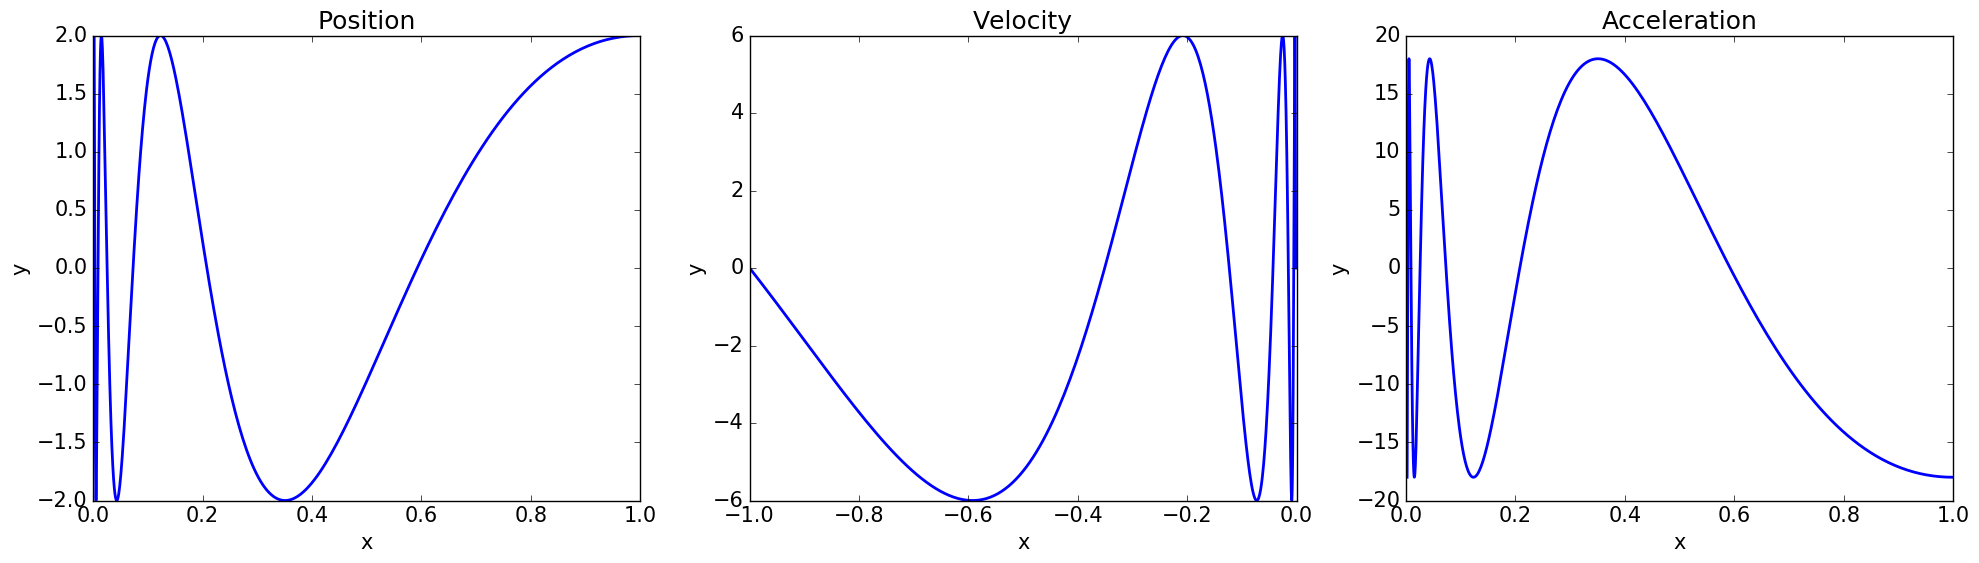

In [15]:
# Plot the solutions
# Initilise the figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot the position
ax1.plot(r_ref[:, 0], r_ref[:, 1])
ax1.set_title('Position')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot the velocity
ax2.plot(v_ref[:, 0], v_ref[:, 1])
ax2.set_title('Velocity')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Plot the acceleration
ax3.plot(a_ref[:, 0], a_ref[:, 1])
ax3.set_title('Acceleration')
ax3.set_xlabel('x')
ax3.set_ylabel('y');

### Numerical differentiation

#### Forward difference method

Now we assume that we only have a finite number of points for the location of the particle, `r`, in time. For this solution, we assume that we only have 20 data points, i.e. `num_points = 20`, for the particle's trajectory in time interval $t = 0 - 2 \pi$s.

In [16]:
# Generate our finite time vector, with 20 points
num_points = 20
t = np.linspace(0, 2*np.pi, num_points)

# Calculate the position used for the numerical term
r_num = np.zeros((num_points, 2))
r_num[:, 0] = np.exp(-t/T1)
r_num[:, 1] = 2.0*np.cos(t/T2)

To calculate the particles velocity and acceleration we need to calculate the first and second derivatives of its position, `r`, with respect to time. Reminds ourselve that here we only have discrete number of points, rather than a continuous function. Hence, a numerical scheme is required.

Python offers the `np.diff()` comand to calculate the difference between consecutive elements in a `numpy` array. The resulting vector is one element shorter than the original, e.g. if `x=[1, 4, 3, 5]`, then `np.diff(x)` returns `[3, -1, 2]`. 

With `dx = np.diff(x)` and `dt = np.diff(t)` the division `dx/dt` gives an approximation of the particle’s velocity in the x direction. The second derivative can be calculated using: 

    np.diff(x,2)/(np.power(dt[0:num_points - 2], 2)

where `np.diff(x,2)` is the second order difference of `x` – using the above example `np.diff(x,2)` returns `[-4, 3]`. 

For our case, we need to apply the differentiation for the $x$ and $y$ direction of the position, which are stored in the first and the second column of `r`, respectively.

In [17]:
# Initialise array for velocity and acceleration
# calculated using forward difference method
v_f = np.zeros((num_points-1, 2))
a_f = np.zeros((num_points-2, 2))

# Forward difference method to calculate velocity
v_f[:, 0] = np.diff(r_num[:, 0]) / np.diff(t)
v_f[:, 1] = np.diff(r_num[:, 1]) / np.diff(t)
# And then the acceleration
# Calculate acceleration
a_f[:, 0] = np.diff(r_num[:, 0], 2) / (np.power(np.diff(t)[0:num_points-2], 2))
a_f[:, 1] = np.diff(r_num[:, 1], 2) / (np.power(np.diff(t)[0:num_points-2], 2))

We can look at our forward difference scheme, with 20 data points, compared to the reference - 'smooth' - result. 

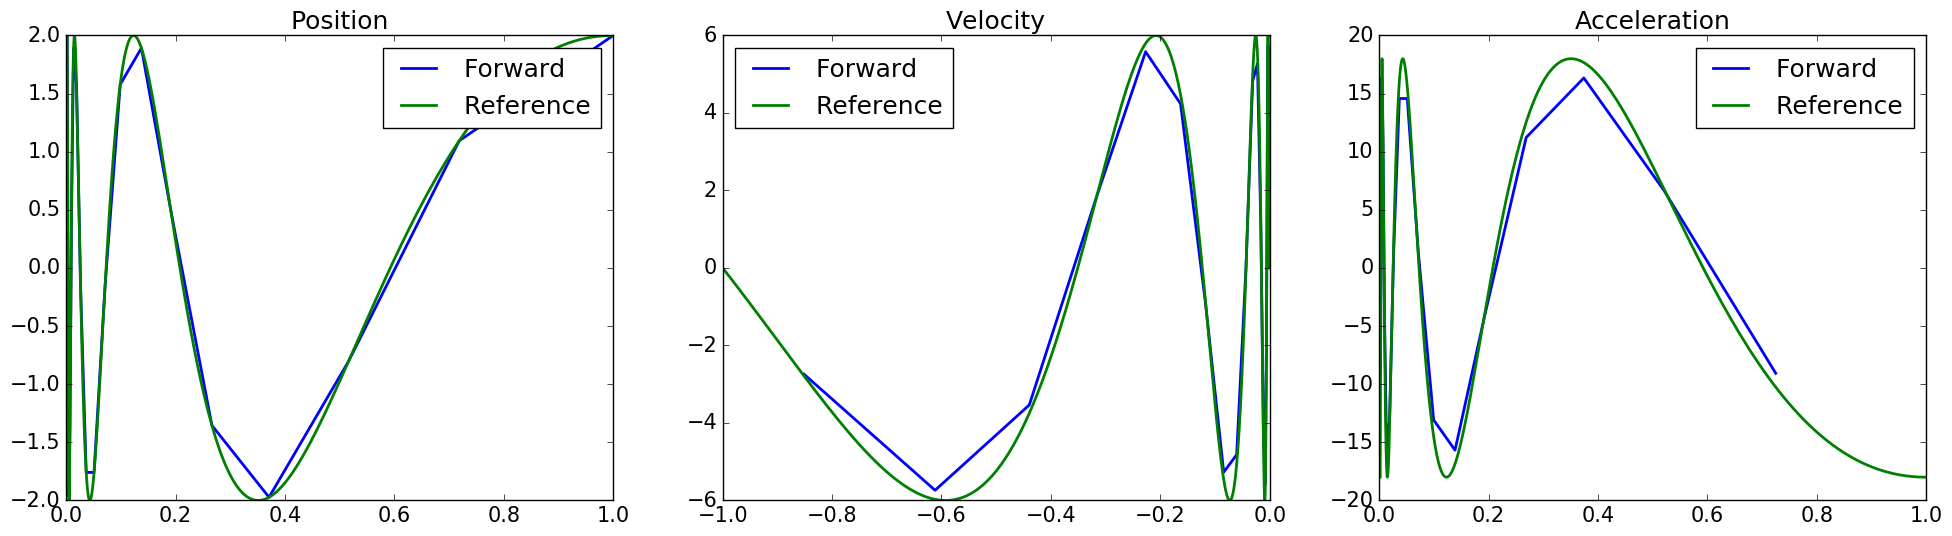

In [18]:
# Generate the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot the position
ax1.plot(r_num[:, 0], r_num[:, 1], label='Forward')
ax1.plot(r_ref[:, 0], r_ref[:, 1], label='Reference')
ax1.set_title('Position')
ax1.legend()

# Plot the velocity
ax2.plot(v_f[:, 0], v_f[:, 1], label='Forward')
ax2.plot(v_ref[:, 0], v_ref[:, 1], label='Reference')
ax2.set_title('Velocity')
ax2.legend(loc=2)

# Plot the acceleration
ax3.plot(a_f[:, 0], a_f[:, 1], label='Forward')
ax3.plot(a_ref[:, 0], a_ref[:, 1], label='Reference')
ax3.set_title('Acceleration')
ax3.legend();

#### Central difference method

In the forward difference method, the current velocity is calculated using the current and the following position. The current acceleration is calculated using the previous and next velocity. This leads to a *mismatch* between velocity on one hand and position and acceleration on the other by one timestep. The centre difference method allows to calculate velocities and accelerations at the same positions over the interval `[1, N-1]`. This method is implemented below, and full understanding is not required. 

In [19]:
# Initialise array for velocity and acceleration
# calculated using central difference method
v_c = np.zeros((num_points-1, 2))
a_c = np.zeros((num_points-2, 2))

# Positions and time difference between adjacent
# elements of position and time. The argument axis=0
# indicates that we carry out np.diff on column-wise 
# of r
dr = np.diff(r_num, axis=0)
dt = np.diff(t)

# Centre difference method
for i in range(1, num_points-1):
    v_c[i-1, :] = (dr[i, :] + dr[i-1, :])/(dt[i] + dt[i-1])
    a_c[i-1, :] = (dr[i, :]/dt[i] - dr[i-1, :]/dt[i-1])/(0.5*(dt[i] + dt[i-1]))

We can quantitatively examine the difference between the forward and central difference scheme to calculate the velocity and the acceleration. Again, here we stick to only 20 data points as before.

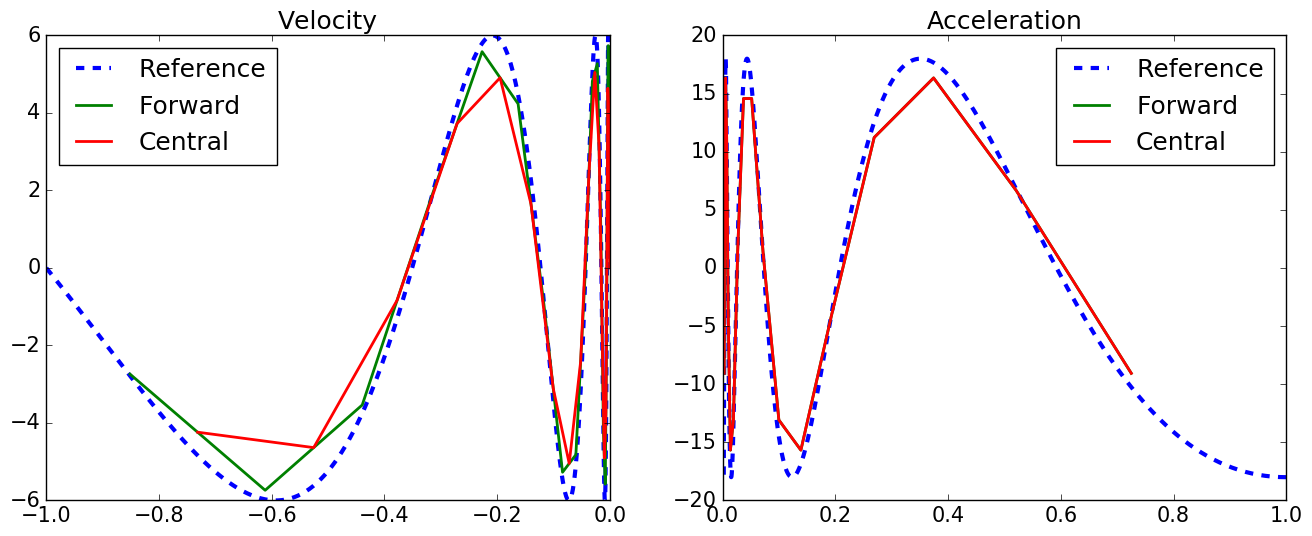

In [20]:
# Generate the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the velocity
ax1.plot(v_ref[:, 0], v_ref[:, 1], label='Reference', lw=3.0, ls='--')
ax1.plot(v_f[:, 0], v_f[:, 1], label='Forward')
ax1.plot(v_c[:, 0], v_c[:, 1], label='Central')
ax1.set_title('Velocity')
ax1.legend(loc=2)

# Plot the acceleration
ax2.plot(a_ref[:, 0], a_ref[:, 1], label='Reference', lw=3.0, ls='--')
ax2.plot(a_f[:, 0], a_f[:, 1], label='Forward')
ax2.plot(a_c[:, 0], a_c[:, 1], label='Central')
ax2.set_title('Acceleration')
ax2.legend();

#### A programmer approach - with interactive!

We can define functions that do our calculations for the forward and central difference method as followed. 

In [21]:
def forward_method(r, t):
    n = len(t)
    
    # Initialise array for velocity and acceleration
    # calculated using forward difference method
    v_for = np.zeros((n-1, 2))
    a_for = np.zeros((n-2, 2))

    # Forward difference method to calculate velocity
    v_for[:, 0] = np.diff(r[:, 0]) / np.diff(t)
    v_for[:, 1] = np.diff(r[:, 1]) / np.diff(t)
    
    # And then the acceleration
    # Calculate acceleration
    a_for[:, 0] = np.diff(r[:, 0], 2) / (np.power(np.diff(t)[0:n-2], 2))
    a_for[:, 1] = np.diff(r[:, 1], 2) / (np.power(np.diff(t)[0:n-2], 2))

    return v_for, a_for

In [22]:
def central_method(r, t):
    # Initialise array for velocity and acceleration
    # calculated using central difference method
    n = len(t)
    v_cen = np.zeros((n, 2))
    a_cen = np.zeros((n, 2))

    # Positions and time difference between adjacent
    # elements of position and time
    dr = np.diff(r, axis=0)
    dt = np.diff(t)

    # Centre difference method
    for i in range(1, n-2):
        v_cen[i-1, :] = (dr[i, :] + dr[i-1, :])/(dt[i] + dt[i-1])
        a_cen[i-1, :] = (dr[i, :]/dt[i] - dr[i-1, :]/dt[i-1]) / (0.5*(dt[i] + dt[i-1]))

    return v_cen, a_cen

By doing so, we can easily calculate the results achieved from either scheme. We can call these functions for the interactive widget, which illustrates the dependence of these two methods on the number of available data points. Full understanding of the code is not required, yet curious students are encouraged to explore. 

In [23]:
# Interactive notebook to compare the two methods
from ipywidgets import *

In [24]:
def compare_difference(num_points):
    t = np.linspace(0, 2*np.pi, num_points)

    # Calculate the position used for the numerical term
    r_num = np.zeros((num_points, 2))
    r_num[:, 0] = np.exp(-t/T1)
    r_num[:, 1] = 2.0*np.cos(t/T2)

    # Forward difference method
    v_for, a_for = forward_method(r_num, t)

    # Central difference metho
    v_cen, a_cen = central_method(r_num, t)

    # Generate the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the velocity
    ax1.plot(v_ref[:, 0], v_ref[:, 1], label='Reference', lw=3.0, ls='--')
    ax1.plot(v_for[:, 0], v_for[:, 1], label='Forward')
    ax1.plot(v_cen[:, 0], v_cen[:, 1], label='Central')
    ax1.set_title('Velocity')
    ax1.legend(loc=2)

    # Plot the acceleration
    ax2.plot(a_ref[:, 0], a_ref[:, 1], label='Reference', lw=3.0, ls='--')
    ax2.plot(a_for[:, 0], a_for[:, 1], label='Forward')
    ax2.plot(a_cen[:, 0], a_cen[:, 1], label='Central')
    ax2.set_title('Acceleration')
    ax2.legend()

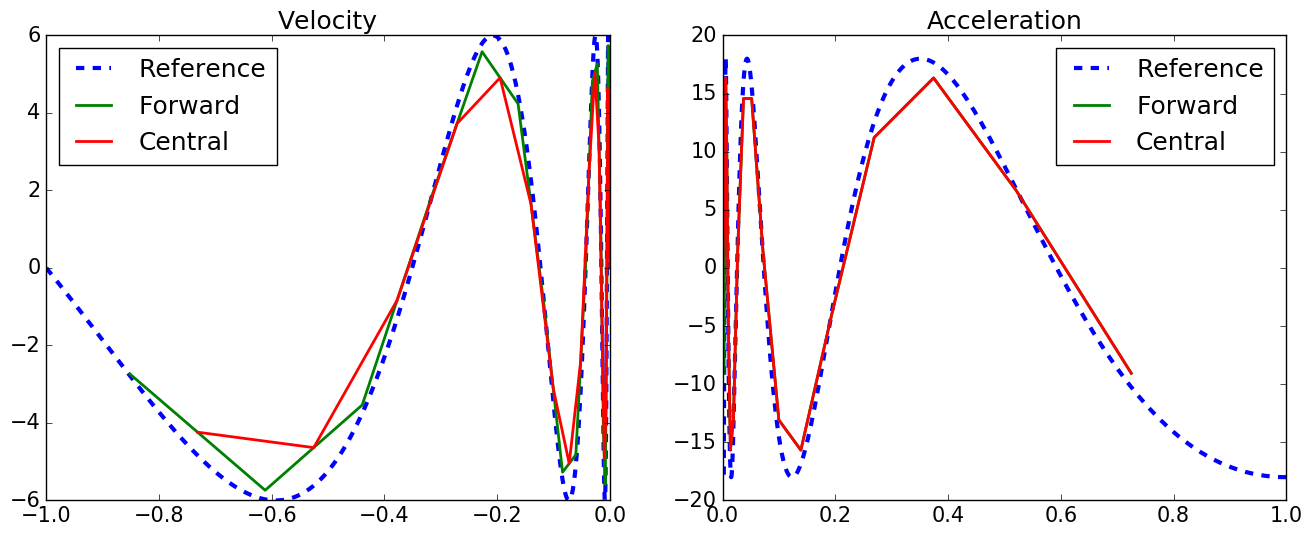

In [25]:
interact(compare_difference, num_points=IntSlider(
        min=10, max=200, step=10, value=20, description='No. points'));

## Question 12

A tracking radar detects an aircraft due south at a range of 10 km. The radar points continually at the aircraft. It measures a range that is decreasing at a constant rate of 200 m s$^{-1}$ while the radar is rotating clockwise at a constant rate of 0.6 deg $^{-1}$.  

1. What is the course (direction) and speed of the aircraft?  
1. What is the component of the aircraft’s acceleration along its path?  
1. What is the value of the instantaneous radius of curvature of the path of the aircraft?  
1. Use Python to produce a plot of the path of the aircraft.  

__Hint__: The command Matplotlib 'pyplot' function `polar(theta, r, 'ro')` will produce a plot of a set of points with polar co-ordinates $(r, \theta)$, where `r` and `theta` are arrays of the same length. Note that $\theta$ must be in radians. It is suggested that you produce a plot for, say, every 2 s between $t = 0$ and $t = 50$ s by defining the array `t = numpy.linspace(0, 50, 26)` and then using Python to calculate the arrays `r` and `theta` for each value of `t`.

### Solution

We first import all relavent modules. We will need the PyPlot from Matplotlib so we can plot our data, and also the `%matplotlib inline` line so we can plot inline in Jupyter notebooks.   We will need the NumPy module so we wan use the commands for arrays and linspace. `numpy.linspace` is a command which creates an array with regularly spaced numbers. 

In [26]:
# Special command for plotting inside a Jupyter notebook
%matplotlib inline

# Import NumPy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

We will create an array to hold the time intervals at which we'll be plotting the aircraft motion (every 2 seconds).  To do this, we use `np.linspace`.

In [27]:
# Create linspace (Note 26 elements for 2 second gaps)
t = np.linspace(0, 50, 26)

Next, we create arrays which hold the values of `r` and `theta` we calculate from the `t` values. We have:

$$
\begin{aligned}
r &= (10000 - 200t)\, \\ 
\theta &= \frac{\pi}{180}(270 - 0.6t)
\end{aligned}
$$

Note that the angle needs to be in radians as this is what the plot function below is expecting.

In [28]:
# Create arrays for r and theta
r_12 = (10000 - 200*t)
theta = (270 - 0.6*t)*(np.pi/180)

Finally, we plot the values we've calculated on a polar plot, using the command `plt.polar(theta, r)` which expects the input variables to be the angle and radial distance.

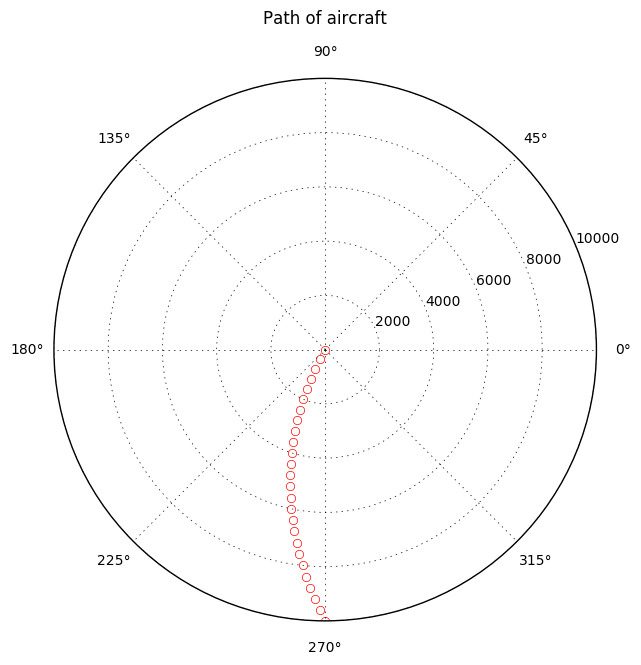

In [29]:
# Creates a figure, with a set size
plt.figure(figsize=(7, 7))

# Plots the data as empty red circles on a set of polar axes
plt.polar(theta, r_12, "o", markerfacecolor='none',  markeredgecolor='r')

# Sets the title (the \n moves the title up so it doesn't overlap the axes)
plt.title("Path of aircraft\n");